This notebook includes:
- Mapping of UniProt IDs to Entrez Gene IDs of EV proteins (of combined EV database dataset)
- Merging of EV proteins with feature dataset to create EV annotation
- Removal of low count proteins (<3)
- Fasta file generation for STREME
- Adding de novo discovered motifs as features

Output dataset:
- training_data.csv
- training_data_no_filtering.csv

# Import libraries

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.parse
import urllib.request

from matplotlib_venn import venn2
from os import listdir
from os.path import isfile, join

# Define paths

In [6]:
# user = 'kathi'
user = 'DeaGogishvili'

Data_path = '/Users/' + user + '/Documents/GitHub/ExtracellularVesicles/Data'

# Import datasets

### Combined EV database dataset

In [7]:
# Exocarta + Vesiclepedia
VPEC_mapped = Data_path + '/Curated/VPEC_mapped.csv'  
VPEC_mapped = pd.read_csv(VPEC_mapped, sep=',', engine='python')

In [8]:
VPEC_mapped

,ENTREZ GENE ID,Uniprot,GENE SYMBOL,OCCURRENCES
0,16,P49588,AARS,124
1,34,P11310,ACADM,42
2,38,P24752,ACAT1,65
3,47,P53396,ACLY,185
4,50,Q99798,ACO2,58
...,...,...,...,...
11839,201456,Q8NCQ5,FBXO15,5
11840,388662,Q9H1V8,SLC6A17,3
11841,55117,Q9H2J7,SLC6A15,1
11842,80217,Q8NDM7,CFAP43,1


### Feature dataset

In [9]:
df_features = Data_path + '/Curated/features_human_proteome.csv' 
df_features = pd.read_csv(df_features, sep=',', engine='python')

In [10]:
df_features_all = Data_path + '/Curated/features_human_proteome_no_filtering.csv' 
df_features_all = pd.read_csv(df_features_all, sep=',', engine='python')

# EV annotation of human proteome

In [11]:
EV_list = list(VPEC_mapped["Uniprot"])
len(EV_list)

11844

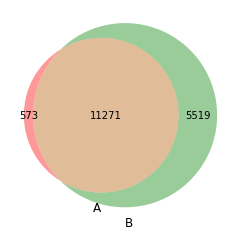

In [12]:
venn2([set(VPEC_mapped["Uniprot"]), set(df_features["id"])]) # some proteins are missing because of MS filtering
plt.show()

In [13]:
# annotate proteins in EV list as EV proteins, missing proteins as non-EV proteins in human proteome
df_features['EV'] = np.where(df_features['id'].isin(EV_list), 1, 0)
df_features_all['EV'] = np.where(df_features_all['id'].isin(EV_list), 1, 0)

In [14]:
print("Number of unique Uniprot IDs mapped to the human proteome dataset:", df_features['EV'].sum())
print("Number of unique Uniprot IDs mapped to the human proteome dataset:", len(df_features) - df_features['EV'].sum())
print("-----------")
print("Fraction of EV proteins in human proteome:", df_features['EV'].sum()/len(df_features))
print("Fraction of non-EV proteins in human proteome:", 1 - df_features['EV'].sum()/len(df_features))

Number of unique Uniprot IDs mapped to the human proteome dataset: 11271
Number of unique Uniprot IDs mapped to the human proteome dataset: 5519
-----------
Fraction of EV proteins in human proteome: 0.671292435973794
Fraction of non-EV proteins in human proteome: 0.32870756402620604


### Removal of low count proteins from dataset

In [15]:
# set maximum number of occurrences that should be removed (inclusive)
low_count = 2
EV_low_count = VPEC_mapped[VPEC_mapped['OCCURRENCES'] <= low_count].copy()

In [16]:
keep = (df_features['id'].isin(EV_low_count["Uniprot"]) == False)
df_features_keep = df_features[keep]

keep = (df_features_all['id'].isin(EV_low_count["Uniprot"]) == False)
df_features_all_keep = df_features_all[keep]

In [17]:
# Check new distribution in data set
print("Number of low count proteins:", (keep == False).sum(), "(REMOVED)")
print("Number of kept proteins:", len(df_features_keep))
print("Number of EV associated proteins:", (df_features_keep["EV"] == 1).sum())
print("Number of non-EV associated proteins:", (df_features_keep["EV"] == 0).sum())

Number of low count proteins: 3441 (REMOVED)
Number of kept proteins: 13717
Number of EV associated proteins: 8198
Number of non-EV associated proteins: 5519


# Save final feature data set

In [18]:
df_features_keep = df_features_keep.drop(columns=['fasta_sequence']) 
df_features_keep.to_csv(Data_path + '/MachineLearning/training_data.csv', index=False)

df_features_all_keep = df_features_all_keep.drop(columns=['fasta_sequence']) 
df_features_all_keep.to_csv(Data_path + '/MachineLearning/training_data_no_filtering.csv', index=False)

# Generate FASTA Files for STREME

### All Data

In [25]:
# all_data = df_features_keep[['id', 'fasta_sequence']]
# all_data['id'] = '>'+all_data['id']

# # change U to C, otherwise STREME doesn't work
# sequences = list(all_data['fasta_sequence'])
# sequences = [sequence.replace('U', 'C') for sequence in sequences]
# all_data['fasta'] = sequences
# all_data = all_data[['id', 'fasta']]

# #all_data.to_csv(Data_path + '/STREME/all_data.FASTA', sep='\n', header=False, index=False)

### Positive Dataset

In [26]:
# positive = df_features_keep[df_features_keep['EV'] == 1]
# positive = positive[['id', 'fasta_sequence']]
# positive['id'] = '>'+positive['id']

# # change U to C
# sequences = list(positive['fasta_sequence'])
# sequences = [sequence.replace('U', 'C') for sequence in sequences]
# positive['fasta'] = sequences
# positive = positive[['id', 'fasta']]

# #positive.to_csv(Data_path + '/STREME/positive.FASTA', sep='\n', header=False, index=False)

### Negative Dataset

In [27]:
# negative = df_features_keep[df_features_keep['EV'] == 0]
# negative = negative[['id', 'fasta_sequence']]
# negative['id'] = '>'+negative['id']

# # change U to C
# sequences = list(negative['fasta_sequence'])
# sequences = [sequence.replace('U', 'C') for sequence in sequences]
# negative['fasta'] = sequences
# negative = negative[['id', 'fasta']]

# #negative.to_csv(Data_path + '/STREME/negative.FASTA', sep='\n', header=False, index=False)